# NLP Final Project Notebook

This notebook contains the main analysis and experiments for the NLP final project.

## Setup

Follow instructions in README.md

Check if Ollama is properly installed and running.

In [ ]:
!./scripts/check_ollama.sh

## Env Example 

Below is an example cell on how to reference and call functions we create in isolated files

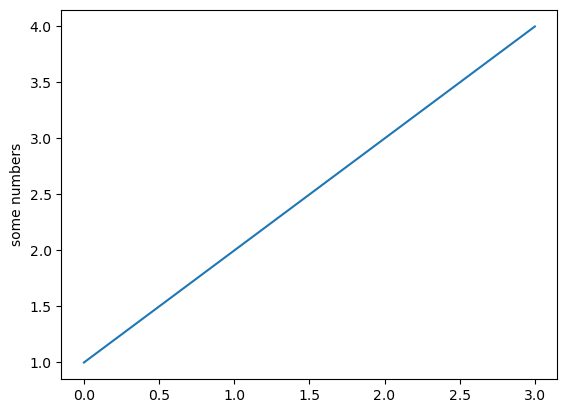

'This is an example function'

In [9]:
from src.visualization.utils import example_plot, example_function

example_plot()
example_function()

# Global Imports

In [2]:
# Standard Library Imports
import json

# Custom Imports
from src.io.ollama_client import OllamaClient

# Example Usage

## OllamaClient Usage

This is the client that wraps the usage of the ollama API, and should be instantiated per model

In [3]:
qwen = OllamaClient("qwen3:0.6b", log_conversations=True)

Run the cell below to generate text from the model, this will generate a standalone response (no context)

In [4]:
qwen.generate_text("Hello, world!")

'Hello, world! 😊 What can I do for you today?'

After running the cell above, the conversation history will be populated with the prompt and response

In [5]:
print(qwen.get_conversation_count())
# The conversation history can be accessed by calling the get_conversation_history method
print(qwen.get_conversation_history())
# The last conversation can be accessed by calling the get_last_conversation method
print(qwen.get_last_conversation())
# The conversation history can be cleared by calling the clear_conversation_history method
# qwen.clear_conversation_history()

1
[{'prompt': 'Hello, world!', 'response': {'model': 'qwen3:0.6b', 'created_at': '2025-10-30T23:09:33.869325Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1150460042, 'load_duration': 558260167, 'prompt_eval_count': 14, 'prompt_eval_duration': 75771583, 'eval_count': 101, 'eval_duration': 485179294, 'response': 'Hello, world! 😊 What can I do for you today?', 'thinking': 'Okay, the user just said "Hello, world!" to me. Let me think about how to respond. First, I should acknowledge their message. It\'s a simple greeting, so a friendly reply would work. Maybe say "Hello, world!" and offer to help with something. That\'s a good approach. I don\'t need to add any extra information here, just keep it straightforward and open-ended.\n', 'context': [151644, 872, 198, 9707, 11, 1879, 0, 608, 26865, 151645, 198, 151644, 77091, 198, 151667, 198, 32313, 11, 279, 1196, 1101, 1053, 330, 9707, 11, 1879, 8958, 311, 752, 13, 6771, 752, 1744, 911, 1246, 311, 5889, 13, 5512, 11, 358, 1265, 24

The response from ollama and stored in the client contains a ton of information if needed. Note the difference in the already parsed thinking and response secitons, this could be used later.

In [6]:
resp = qwen.get_last_conversation().get("response")
print(json.dumps(resp, indent=4))

{
    "model": "qwen3:0.6b",
    "created_at": "2025-10-30T23:09:33.869325Z",
    "done": true,
    "done_reason": "stop",
    "total_duration": 1150460042,
    "load_duration": 558260167,
    "prompt_eval_count": 14,
    "prompt_eval_duration": 75771583,
    "eval_count": 101,
    "eval_duration": 485179294,
    "response": "Hello, world! \ud83d\ude0a What can I do for you today?",
    "thinking": "Okay, the user just said \"Hello, world!\" to me. Let me think about how to respond. First, I should acknowledge their message. It's a simple greeting, so a friendly reply would work. Maybe say \"Hello, world!\" and offer to help with something. That's a good approach. I don't need to add any extra information here, just keep it straightforward and open-ended.\n",
    "context": [
        151644,
        872,
        198,
        9707,
        11,
        1879,
        0,
        608,
        26865,
        151645,
        198,
        151644,
        77091,
        198,
        151667,
   

Or more simply

In [8]:
qwen.get_last_response_text()

'Hello, world! 😊 What can I do for you today?'

Depending on how you choose to setup your experiments, you can choose to use the cached responses in the client class, or keep track of the inputs and outputs outside of the client, either is fine just use `log_conversations=False` to prevent memory bloat if you are doing it yourself. I imagine keeping it within the class will work better, then appending a new message like `prompt + qwen.get_last_response()` for the output test. This way, we can parse the message history into formats used for calculating embeddings, drift, accelertaion etc.